<a href="https://colab.research.google.com/github/PageOfPages/Boids/blob/master/Current_Simulate_potential_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fractions import Fraction
import math
import random 
from collections import defaultdict
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [ ]:
evolution = []
neighbors = []
precision = 0.000001

In [ ]:
def neighborhood(config):
    """
    Args:
        config (dict): point-index -> position fraction
    Returns:
        ((dict) point-index: slice(leftend, rightend) of point-indexes 
        of current neighbors
    """
    points = sorted(config.keys()) # assumed to be 0,1,2,...,n-1 in sequence
    n = len(points)
    result = defaultdict(tuple)
    for pt in points:
        left_end = pt
        for i in reversed(range(0, pt)):
            if config[pt] - config[i] <= 1:
                left_end = i
            else:
                break
        right_end = pt+1
        while right_end < n:
            if config[right_end] - config[pt] <= 1:
                right_end += 1
            else:
                break
        result[pt] = slice(left_end, right_end)
    return result

In [ ]:
def hk_next_config(config):
    """Returns the next configuration
    Args:
        config (dict): point-index -> position fraction
    """
    n = len(config)
    pos_lst = [config[i] for i in range(n)]
    curr_neigh = neighborhood(config)
    next_config = defaultdict(Fraction)
    for pt in config:
        left_end, right_end = curr_neigh[pt].start, curr_neigh[pt].stop
        next_config[pt] = sum(pos_lst[left_end:right_end])/(right_end - left_end)
    return next_config

In [ ]:
def isclose(config1, config2):
    """Checks if config1 and config2 are close enough to be deemed equal
    Args:
        config1, config2 (dict): successive HK dynamics configurations
    """
    return all ([math.isclose(config1[pt], config2[pt]) for pt in config1])

In [ ]:
def dumbbellHK(n):
    """Creates a dumbbell 
    The "bar" has n+1 >= 3 equally spaced points at 0, 1, ..., n 
    while the "bells" at each end have n points at distance 1/n 
    from the ends
    Args:
        n (int): n >= 2
    Returns:
        dictionary of point-indices and corresponding position fractions
    """
    d = defaultdict(Fraction)
    for pt in range(0, n):
        d[pt] = Fraction(-1, n)
    for pt in range(n, (2*n+1)+1):
        d[pt] = Fraction(pt -((n-1)+1), 1)
    for pt in range(2*n+1, 3*n+1):
        d[pt] = Fraction(n*n + 1, n)
    return d

In [ ]:
def uniformHK(n):
    """
    Args:
        n number of agents
    Returns:
        ((dict) point-index: point-indexes 
        of a uniform initial configuration 
    """
    return dict([(i, Fraction(i)) for i in range(n)])

In [183]:
def clusterHK(n, incrementTop, incrementBottom, group_size): 
    """
    Args:
        ???
    Returns:
        ???
    """
    steps = uniformHK(n)
    for i in range(0,group_size):
        steps[i+1]+=Fraction(incrementTop).limit_denominator()
        steps[n-i]+=Fraction(incrementBottom).limit_denominator()
    return steps  

In [184]:
#Need to fix for 0-(n-1) and we need DOCUMENTATION!!
def exponentialHK(n, alpha): 
    """
    Args:
        n number of agents
    Returns:
        ((dict) point-index: point-indexes 
        of an exponential initial configuration
    """
    steps = uniformHK(n)
    mid = math.ceil(n/2) - 1
    for i in range(0,mid):
        steps[mid-i-1] = Fraction(steps[mid-i] - alpha**(i)).limit_denominator()
        steps[mid+i+1] = Fraction(steps[mid+i] + alpha**(i)).limit_denominator()
    return steps

In [ ]:
def randomHK(n):
    """
    Args:
        n number of agents
    Returns:
        ((dict) point-index: point-indexes 
        of a random initial configuration
    """
    return dict(zip(range(n), sorted(random.uniform(0,n) for i in range(n))))

In [182]:
def hk_potential(config):
    '''Calculates Potential of system
    Args: current system of agents
    Returns: sum of potential in current system
    !!! TIME COMPLEXITY TOO BIG !!!
    '''
    curr_neigh = neighborhood(config) #dict of pts and each pt's endpoints stored in a slice
    potential = 0
    for pt in config: #looking at the value of each point in config, ex. agent 1 at step one is 1.5
      left_end, right_end = curr_neigh[pt].start, curr_neigh[pt].stop
      sqr_dist_sum = 0
      for c in range(left_end, right_end-1):
        for d in range(c+1, right_end):
          sqr_dist_sum += ((config[c] - config[d]))**2
      potential += sqr_dist_sum/(right_end-left_end)
              
    return potential

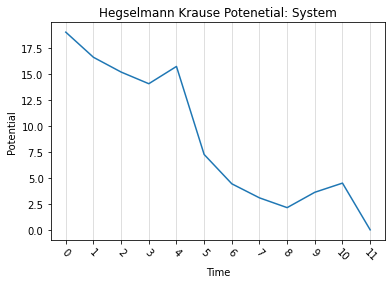

In [187]:
def simulate_potential(init_system):
    """Determine HK dynamics of system
    Args:
        init_system (dict): initial configuration of agents
    """
    step = 0
    p_evol = [] #record potential on initial system
    evolution = defaultdict(dict)
    evolution[step] = init_system
    while True: # update the system
        step += 1
        evolution[step] = hk_next_config(evolution[step-1])
        ptl = hk_potential(evolution[step-1])
        p_evol.append(ptl)
        if isclose(evolution[step], evolution[step-1]):
            break

    fig, ax = plt.subplots()
    ax.set_title('Hegselmann Krause Potenetial: System')
    ax.set_xlabel('Time')
    ax.set_ylabel('Potential')
    if (step >= 10):
      majorLocator = MultipleLocator(int(step/10))
    else:
      majorLocator = MultipleLocator(1)
    ax.xaxis.set_major_locator(majorLocator)
    plt.xticks(rotation=-45)
    stages = list(range(len(p_evol)))
    plt.plot(p_evol)
    plt.grid(axis='x', alpha=0.5) 

# simulate_potential(exponentialHK(11,0.99))
# simulate_potential(dumbbellHK(11))
simulate_potential(uniformHK(11))

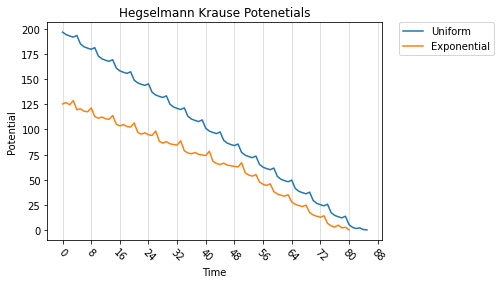

In [188]:
def compare_potentials(n,alpha):
    """Determine HK dynamics of system
    Args:
        init_system (dict): initial configuration of agents
    """
    
    # systems = [uniformHK(n), exponentialHK(n,alpha), dumbbellHK(n)]
    systems = [uniformHK(n), exponentialHK(n,alpha)]
    potentials = []
    
    for init_system in systems:
      step = 0
      p_evol = [] #record potential on initial system
      evolution = defaultdict(dict)
      evolution[step] = init_system
      while True: # update the system
          step += 1
          evolution[step] = hk_next_config(evolution[step-1])
          ptl = hk_potential(evolution[step-1])
          p_evol.append(ptl)
          if isclose(evolution[step], evolution[step-1]):
              break
      potentials.append(p_evol)

    fig, ax = plt.subplots()
    ax.set_title('Hegselmann Krause Potenetials')
    ax.set_xlabel('Time')
    ax.set_ylabel('Potential')
    if (step >= 10):
      majorLocator = MultipleLocator(int(step/10))
    else:
      majorLocator = MultipleLocator(1)
    ax.xaxis.set_major_locator(majorLocator)
    plt.xticks(rotation=-45)
    
    x = potentials[0] 
    ax.plot(x, label="Uniform")
    y = potentials[1] 
    ax.plot(y, label="Exponential")
    # z = potentials[2] 
    # ax.plot(z, label="Dumbbell")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(axis='x', alpha=0.5) 

compare_potentials(100,.99)